In [1]:
CUDA_VISIBLE_DEVICES=""

import pandas as pd       
import matplotlib as mat
import matplotlib.pyplot as plt    
import numpy as np
import seaborn as sns
%matplotlib inline

import random
import os

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import glob
import cv2

import warnings
warnings.filterwarnings('ignore')

import sys
print(sys.version)

2023-01-08 18:40:19.206235: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-08 18:40:19.794006: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-08 18:40:19.879070: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-08 18:40:19.879122: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

3.10.8 (main, Nov 24 2022, 14:13:03) [GCC 11.2.0]


In [2]:
IMG_SIZE = 224
BATCH = 32
SEED = 42

np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

tf.keras.utils.set_random_seed(42)

os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [3]:
main_path = "scaled_chest_xray"

train_normal = glob.glob(main_path+"/train/NORMAL/*.jpeg")
train_pneumonia = glob.glob(main_path+"/train/PNEUMONIA/*.jpeg")

test_normal = glob.glob(main_path+"/test/NORMAL/*.jpeg")
test_pneumonia = glob.glob(main_path+"/test/PNEUMONIA/*.jpeg")

In [4]:
train_list = [x for x in train_normal]
train_list.extend([x for x in train_pneumonia])

df_train = pd.DataFrame(np.concatenate([['Normal']*len(train_normal) , ['Pneumonia']*len(train_pneumonia)]), columns = ['class'])
df_train['image'] = [x for x in train_list]

test_list = [x for x in test_normal]
test_list.extend([x for x in test_pneumonia])

df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal) , ['Pneumonia']*len(test_pneumonia)]), columns = ['class'])
df_test['image'] = [x for x in test_list]

In [5]:
df_train

,class,image
0,Normal,scaled_chest_xray/train/NORMAL/NORMAL-7061169-...
1,Normal,scaled_chest_xray/train/NORMAL/NORMAL-5332597-...
2,Normal,scaled_chest_xray/train/NORMAL/NORMAL-1476994-...
3,Normal,scaled_chest_xray/train/NORMAL/NORMAL-5708209-...
4,Normal,scaled_chest_xray/train/NORMAL/NORMAL-963312-0...
...,...,...
5227,Pneumonia,scaled_chest_xray/train/PNEUMONIA/VIRUS-111494...
5228,Pneumonia,scaled_chest_xray/train/PNEUMONIA/BACTERIA-338...
5229,Pneumonia,scaled_chest_xray/train/PNEUMONIA/VIRUS-980171...
5230,Pneumonia,scaled_chest_xray/train/PNEUMONIA/BACTERIA-799...


In [6]:
df_test

,class,image
0,Normal,scaled_chest_xray/test/NORMAL/NORMAL-1768815-0...
1,Normal,scaled_chest_xray/test/NORMAL/NORMAL-9217241-0...
2,Normal,scaled_chest_xray/test/NORMAL/NORMAL-1608079-0...
3,Normal,scaled_chest_xray/test/NORMAL/NORMAL-7488601-0...
4,Normal,scaled_chest_xray/test/NORMAL/NORMAL-3518268-0...
...,...,...
619,Pneumonia,scaled_chest_xray/test/PNEUMONIA/BACTERIA-6105...
620,Pneumonia,scaled_chest_xray/test/PNEUMONIA/VIRUS-6828836...
621,Pneumonia,scaled_chest_xray/test/PNEUMONIA/BACTERIA-6950...
622,Pneumonia,scaled_chest_xray/test/PNEUMONIA/BACTERIA-6950...


# <a id="3">Exploring the Data</a>

Let's check the sizes of the training dataset

In [7]:
print("Size of training set: " + str(len(df_train)))

Size of training set: 5232


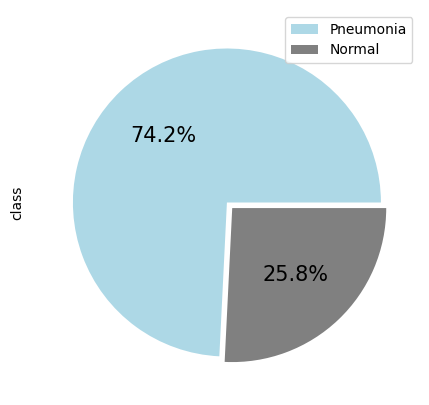

In [8]:
plt.figure(figsize=(7,5))

df_train['class'].value_counts().plot(kind='pie',labels = ['',''], autopct='%1.1f%%', colors = ['lightblue','gray'], explode = [0,0.05], textprops = {"fontsize":15})

plt.legend(labels=['Pneumonia', 'Normal'])
plt.show()

Let's check the sizes of the test dataset

In [9]:
print("Size of test set: " + str(len(df_test)))

Size of test set: 624


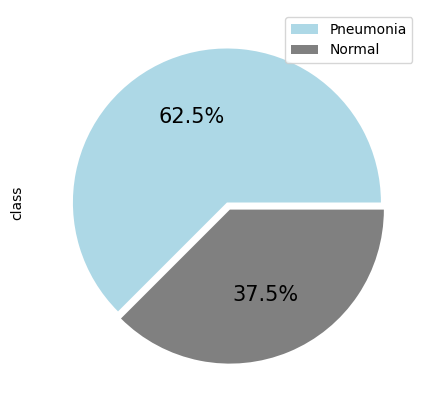

In [10]:
plt.figure(figsize=(7,5))

df_test['class'].value_counts().plot(kind='pie',labels = ['',''], autopct='%1.1f%%', colors = ['lightblue','gray'], explode = [0,0.05], textprops = {"fontsize":15})

plt.legend(labels=['Pneumonia', 'Normal'])
plt.show()

# <a id="4">Preparing the Data</a>

Until now we have no validation set.
We can create a validation set by splitting the training set into a validation and training set.

In [11]:
train_df, val_df = train_test_split(df_train, test_size = 0.20, random_state = SEED, stratify = df_train['class'])

In [12]:
print("Size of training set: " + str(len(train_df)))
train_df

Size of training set: 4185


,class,image
3566,Pneumonia,scaled_chest_xray/train/PNEUMONIA/BACTERIA-793...
2866,Pneumonia,scaled_chest_xray/train/PNEUMONIA/VIRUS-861405...
2681,Pneumonia,scaled_chest_xray/train/PNEUMONIA/VIRUS-318228...
1199,Normal,scaled_chest_xray/train/NORMAL/NORMAL-3678361-...
4619,Pneumonia,scaled_chest_xray/train/PNEUMONIA/VIRUS-936190...
...,...,...
3476,Pneumonia,scaled_chest_xray/train/PNEUMONIA/BACTERIA-556...
678,Normal,scaled_chest_xray/train/NORMAL/NORMAL-5021371-...
1560,Pneumonia,scaled_chest_xray/train/PNEUMONIA/VIRUS-234758...
2769,Pneumonia,scaled_chest_xray/train/PNEUMONIA/BACTERIA-512...


In [13]:
print("Size of validation set: " + str(len(val_df)))
val_df

Size of validation set: 1047


,class,image
2945,Pneumonia,scaled_chest_xray/train/PNEUMONIA/BACTERIA-706...
4878,Pneumonia,scaled_chest_xray/train/PNEUMONIA/VIRUS-336151...
3177,Pneumonia,scaled_chest_xray/train/PNEUMONIA/BACTERIA-983...
972,Normal,scaled_chest_xray/train/NORMAL/NORMAL-6891737-...
3059,Pneumonia,scaled_chest_xray/train/PNEUMONIA/BACTERIA-753...
...,...,...
253,Normal,scaled_chest_xray/train/NORMAL/NORMAL-5315468-...
4315,Pneumonia,scaled_chest_xray/train/PNEUMONIA/BACTERIA-961...
687,Normal,scaled_chest_xray/train/NORMAL/NORMAL-1150393-...
3417,Pneumonia,scaled_chest_xray/train/PNEUMONIA/BACTERIA-884...


In [14]:


# https://vijayabhaskar96.medium.com/tutorial-on-keras-flow-from-dataframe-1fd4493d237c

train_datagen = ImageDataGenerator(rescale=1/255.,
                                  zoom_range = 0.1,
                                  #rotation_range = 0.1,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1)

val_datagen = ImageDataGenerator(rescale=1/255.)

ds_train = train_datagen.flow_from_dataframe(train_df,
                                             #directory=train_path, #dataframe contains the full paths
                                             x_col = 'image',
                                             y_col = 'class',
                                             target_size = (IMG_SIZE, IMG_SIZE),
                                             class_mode = 'binary',
                                             batch_size = BATCH,
                                             seed = SEED)

ds_val = val_datagen.flow_from_dataframe(val_df,
                                            #directory=train_path,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = BATCH,
                                            seed = SEED)

ds_test = val_datagen.flow_from_dataframe(df_test,
                                            #directory=test_path,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = 1,
                                            shuffle = False)

Found 4185 validated image filenames belonging to 2 classes.
Found 1047 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


In [15]:
#Setting callbakcs

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=1e-7,
    restore_best_weights=True,
)

plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,                                     
    patience = 2,                                   
    min_delt = 1e-7,                                
    cooldown = 0,                               
    verbose = 1
) 

In [16]:
def get_model():
    
    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    # Block One
    x = layers.Conv2D(filters=16, kernel_size=3, padding='valid')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.2)(x)

    # Block Two
    x = layers.Conv2D(filters=32, kernel_size=3, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.2)(x)
    
    # Block Three
    x = layers.Conv2D(filters=64, kernel_size=3, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.4)(x)

    # Head
    #x = layers.BatchNormalization()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model

In [ ]:
keras.backend.clear_session()

model = get_model()
model.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=3e-5), metrics='binary_accuracy')

model.summary()

In [ ]:
history = model.fit(ds_train,
          batch_size = BATCH, epochs = 5,
          validation_data=ds_val,
          callbacks=[early_stopping, plateau],
          steps_per_epoch=(len(train_df)/BATCH),
          validation_steps=(len(val_df)/BATCH));

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['loss'])
sns.lineplot(x = history.epoch, y = history.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 0.5)
ax.legend(['train', 'val'], loc='best')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['binary_accuracy'])
sns.lineplot(x = history.epoch, y = history.history['val_binary_accuracy'])
ax.set_title('Learning Curve (Accuracy)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0.80, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

In [ ]:
score = model.evaluate(ds_val, steps = len(val_df)/BATCH, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

In [ ]:
score = model.evaluate(ds_test, steps = len(df_test), verbose = 0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])